# Introduction
__The Goal__ - Develop an unsupervised learning approach to group patent claims into distinct topics.</br>
In this notebook I will show various approaches for the goal:</br>
1. __K-Means__: K-means is a popular clustering algorithm that partitions data into K distinct clusters based on feature similarity, optimizing the position of centroids to minimize the variance within each cluster.</br></br>
2. __Hierarchical Clustering__: Hierarchical clustering builds a tree of clusters where each node is a cluster consisting of the clusters of its daughter nodes, starting from individual elements and merging them into larger clusters based on a distance metric.</br></br>
3. __GPT-2 Embeddings with K-means__: This method combines the linguistic understanding capabilities of GPT-2, with K-means clustering to group texts or documents into clusters based on their semantic similarity.</br></br>

Websites:
1. https://www.displayr.com/understanding-cluster-analysis-a-comprehensive-guide/
2. https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
3. https://medium.com/@sachinsoni600517/mastering-hierarchical-clustering-from-basic-to-advanced-5e770260bf93
4. https://medium.com/@danielafrimi/text-clustering-using-nlp-techniques-c2e6b08b6e95
5. https://vitalflux.com/find-topics-of-text-clustering-python-examples/
6. https://spotintelligence.com/2023/01/17/text-clustering-algorithms/

# Data Exploring

## 1. Data fetching and preprocessing
Load the pre-processed patent claims data as DataFrame and checking for any missing data values.</br>
Load the TF-IDF matrix as well.

In [184]:
import pandas as pd

# Load data
data_path = 'normalized_patent_claims.csv'
df = pd.read_csv(data_path)


In [185]:
# Display first 5 rows and shape
print(f"Shape of dataframe: {df.shape}")
df.head()

Shape of dataframe: (61, 2)


,Patent URL,Normalized Claim
0,https://patents.google.com/patent/GB2478972A/e...,claim wireless telephone apparatus comprising ...
1,https://patents.google.com/patent/GB2478972A/e...,apparatus claim ftirther comprising body cradl...
2,https://patents.google.com/patent/GB2478972A/e...,apparatus claim ftirther comprising call recei...
3,https://patents.google.com/patent/GB2478972A/e...,apparatus claim wherein first predetermined bu...
4,https://patents.google.com/patent/GB2478972A/e...,apparatus claim wherein transfer mean toggle f...


In [186]:
# Check for missing values
missing_data = df['Normalized Claim'].isnull().sum()
print(f"Number of missing values in 'normalized_claims': {missing_data}")

Number of missing values in 'normalized_claims': 0


In [187]:
def count_unique_words(df: pd.DataFrame):
    # Initialize an empty set to store unique words
    unique_words = set()

    # Iterate over each normalized claim in the DataFrame
    for claim in df['Normalized Claim']:
        # Split the claim into words and update the set
        # This assumes words are separated by spaces and are already normalized (lowercased, no punctuation)
        words = claim.split()
        unique_words.update(words)
    
    return unique_words

print(f"There are {len(count_unique_words(df))} unique words.")

There are 249 unique words.


In [188]:
from scipy import sparse

matrix_path = 'tfidf_matrix.npz'
tfidf_matrix = sparse.load_npz(matrix_path)

# Show the shape of the matrix
print(f"Shape of TF-IDF matrix: {tfidf_matrix.shape}")

Shape of TF-IDF matrix: (61, 249)


For the above I wanted to check if the dimensions of the matrix and the unique words from the DataFrame are equal. 

## 2. Experiment Models

### 2.1 K-Means

In [189]:
# Import necessary libraries
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [190]:
# Number of clusters
sse = []
n = 11

# Initialize and fit K-Means
for k in range (1, n):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    sse.append(kmeans.inertia_)

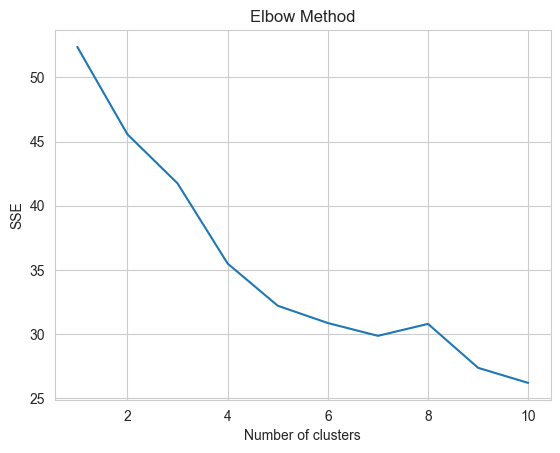

In [191]:
# Plotting
sns.set_style("whitegrid")
g = sns.lineplot(x=range(1, n), y=sse)

g.set(xlabel="Number of clusters", ylabel="SSE", title='Elbow Method')

plt.show()

### 2.2 Elbow Method
Used to determine the optimal number of clusters by plotting SSE and looking for the 'elbow point', in the graph above it's around 6-7 clusters. </br>
I'll try to use clusters around this number to see what gives me the best result.

In [192]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # Principal Component Analysis for dimensionality reduction
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score # silhouette score - measure of how well each data point fits into its cluster
from scipy.sparse import csr_matrix # Compressed Sparse Row - used for sparse matrices

def cluster_and_visualize(tfidf_matrix: csr_matrix, k: int):
    """
    Cluster the given TF-IDF matrix using K-Means and visualize the clusters.
    
    Parameters:
    tfidf_matrix (csr_matrix): The TF-IDF matrix to be clustered in csr format.
    k (int): The number of clusters to create.
    
    Returns:
    None. The function only prints the average silhouette score for each cluster and visualizes the clusters in a 2D plot.
    """
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    
    # Retrieve the cluster labels
    cluster_labels = kmeans.labels_
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
    print(f"For {k} clusters, the average silhouette score is: {100*silhouette_avg:.2f}%")
    
    # Reduce dimensions to 2D using PCA for visualization
    pca = PCA(n_components=2) # Set PCA to 2D
    reduced_features = pca.fit_transform(tfidf_matrix.toarray()) # Transform the TF-IDF matrix to 2D
    centroids = kmeans.cluster_centers_
    reduced_centroids = pca.transform(centroids) # Transform the centroids to 2D
    
    # Create a color map
    cmap = plt.get_cmap('tab10')
    colors = [cmap(i) for i in np.linspace(0, 1, k)]
    
    # Plotting
    plt.figure(figsize=(10, 8))
    for i, color in enumerate(colors):
        plt.scatter(reduced_features[cluster_labels == i, 0], reduced_features[cluster_labels == i, 1], 
                    color=color, label=f'Cluster {i}', alpha=1)

    # Plot centroids
    plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], marker='x', s=150, c='black', label='Centroids')
    plt.title(f'2D PCA of {k} Clusters with Centroids')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(loc='best')
    plt.show()

For 2 clusters, the average silhouette score is: 12.74%


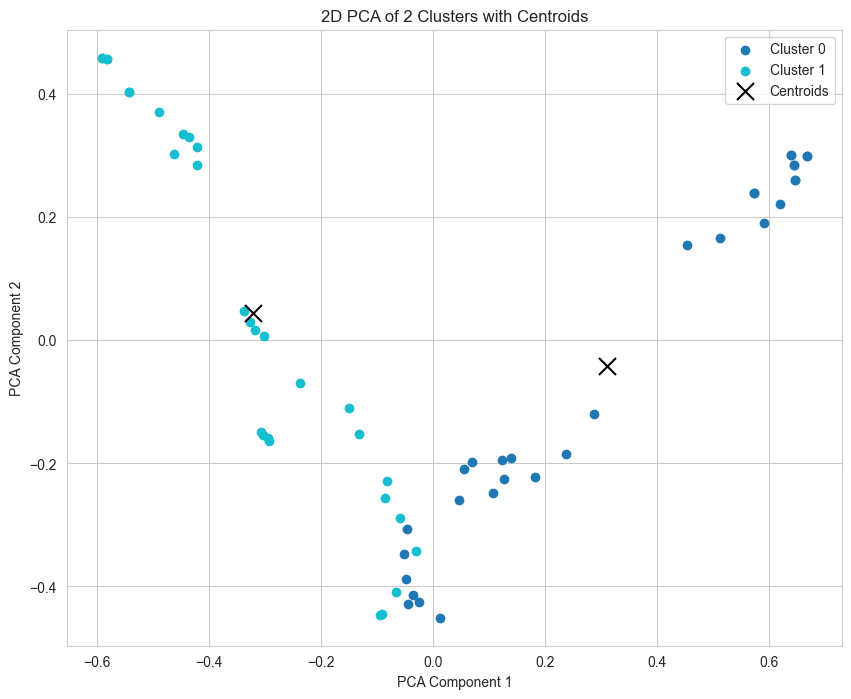

For 3 clusters, the average silhouette score is: 13.83%


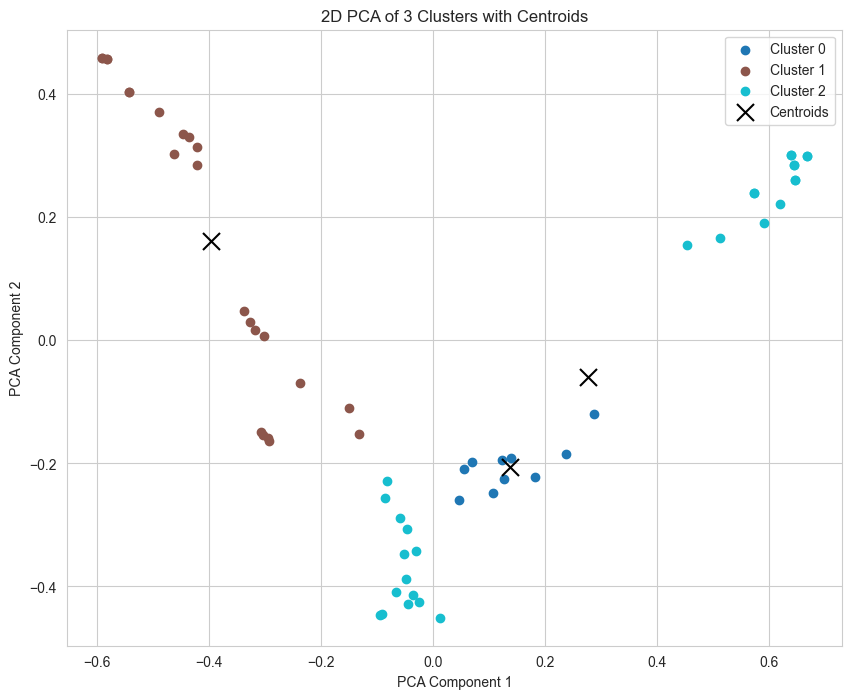

For 4 clusters, the average silhouette score is: 20.20%


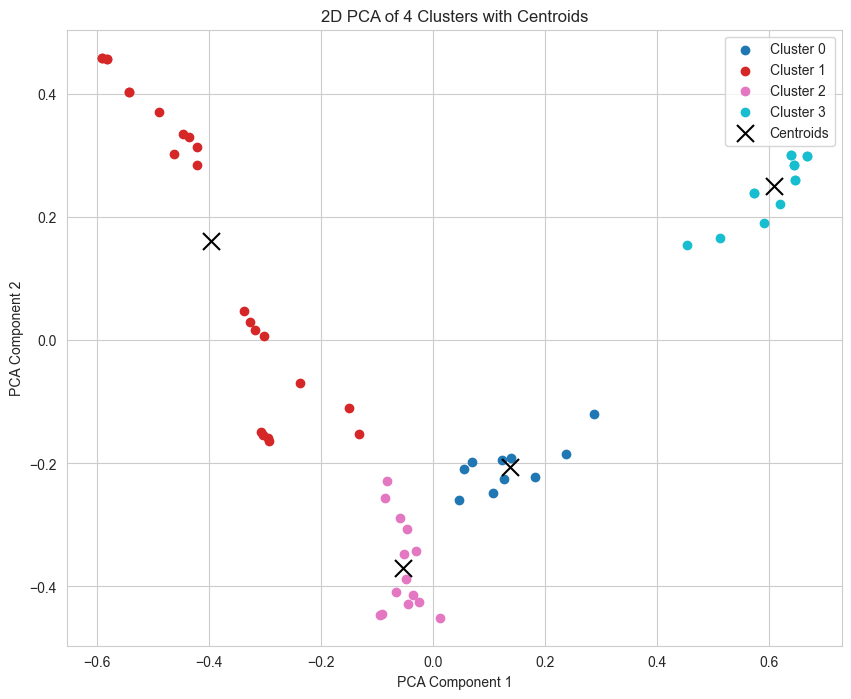

For 5 clusters, the average silhouette score is: 22.44%


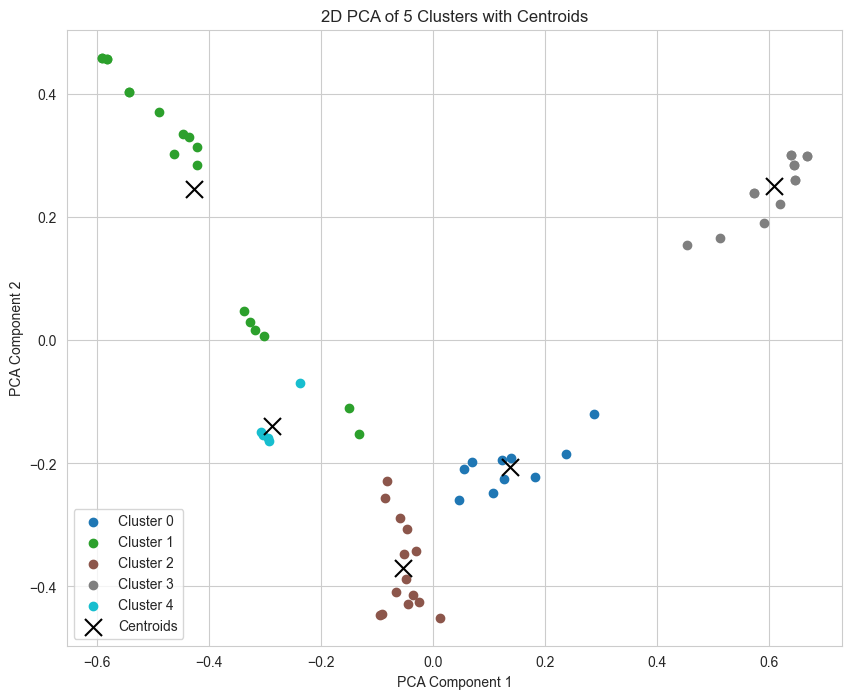

For 6 clusters, the average silhouette score is: 22.49%


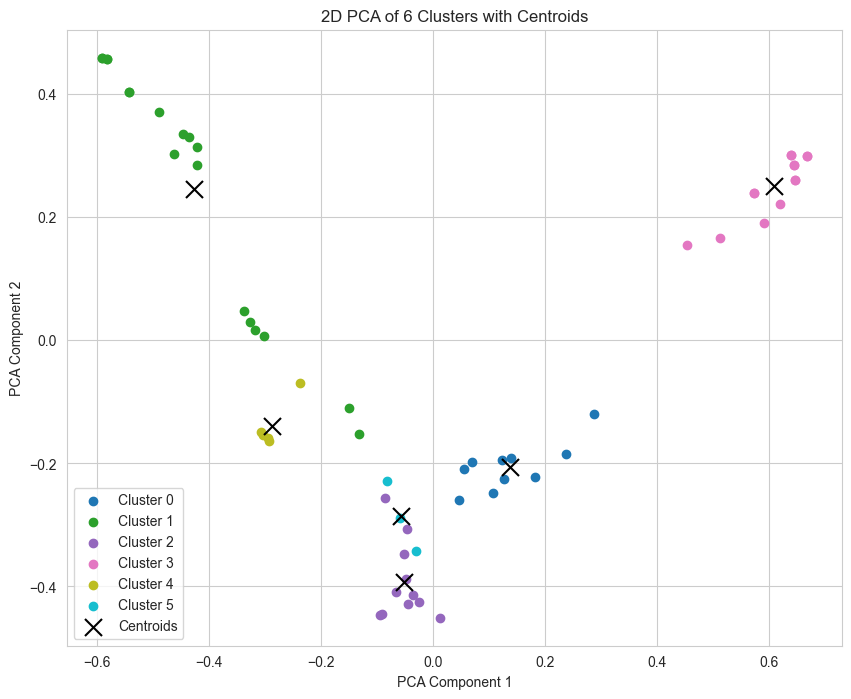

For 7 clusters, the average silhouette score is: 21.41%


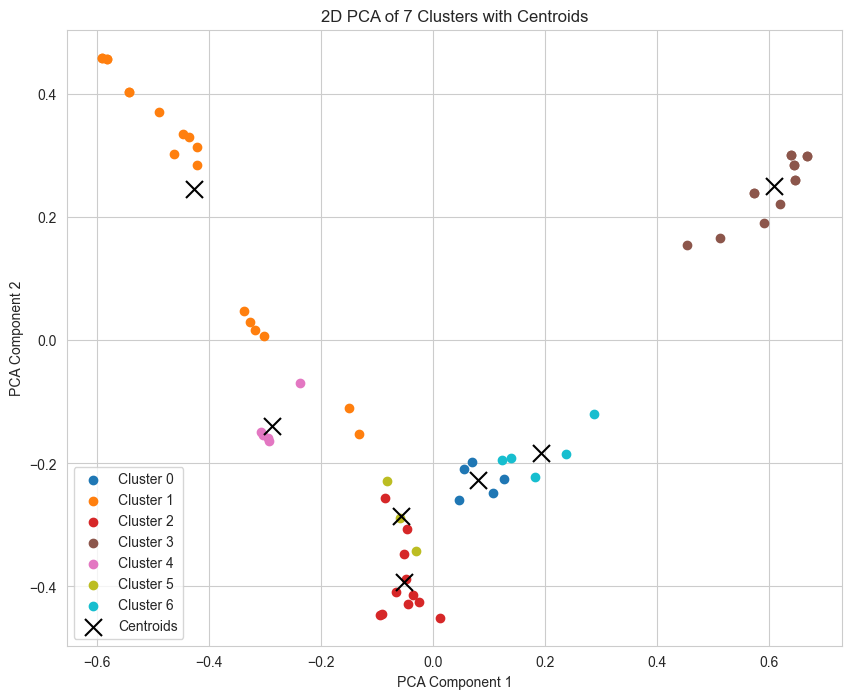

In [193]:
for i in range(2, 8):
    cluster_and_visualize(tfidf_matrix, k=i)

Based on these resulst, I'll use `k = 4` for two reasons:</br>
1. The groups distribution is better</br>
2. The silhouette score is not so different from `k = 5, 6`

In [194]:
# The chosen number of clusters
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(tfidf_matrix)

# Get cluster labels
cluster_labels = kmeans.labels_

# Load original data to attach labels
df = pd.read_csv('normalized_patent_claims.csv')
df['Cluster Label'] = cluster_labels

# Save the DataFrame for further analysis
df.to_csv('kmeans_cluster_labels.csv', index=False)

### 2.3 Hierarchical Clustering

In [195]:
# Import the necessary libraries
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.sparse import load_npz

In [196]:
# Load the TF-IDF matrix
tfidf_matrix = load_npz('tfidf_matrix.npz')

# Generate the linkage matrix using Ward's method
Z = linkage(tfidf_matrix.toarray(), method='ward')

__Linkage__ refers to the criterion used to determine the distance between sets of observations in hierarchical clustering. It is a key component of the algorithm that dictates how the distance between clusters is measured and thus how the clusters are formed.</br></br>
* __Single Linkage__: The distance between two clusters is defined as the shortest distance between points in the two clusters.
* __Complete Linkage__: The distance between two clusters is defined as the longest distance between points in the two clusters.
* __Average Linkage__: The distance between two clusters is the average distance between all pairs of points in the clusters.
* __Ward’s Linkage__: The distance between two clusters is the increase in the total within-cluster variance after merging them.


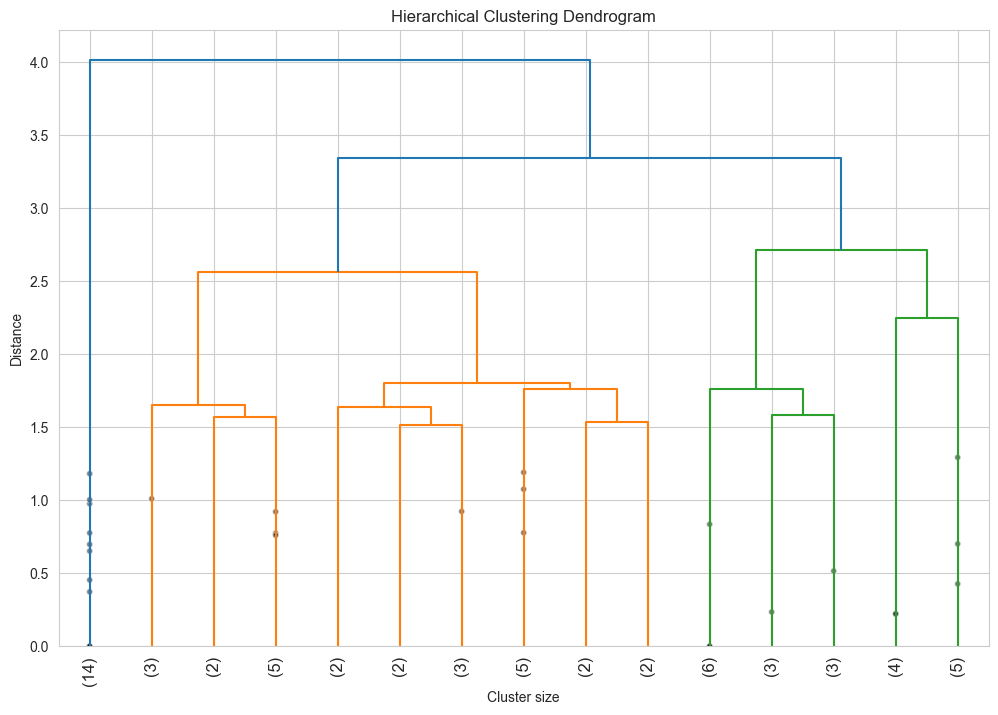

In [197]:
# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=15,  # show only the last 12 merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True  # to get a feel for the distribution inside the larger clusters
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()

- A __dendrogram__ is a type of tree diagram frequently used to illustrate the arrangement of the clusters produced by hierarchical clustering.</br>
It shows the hierarchical relationship between objects, where each merge of clusters or objects is represented by a node, and the height of the nodes illustrates the distance or dissimilarity between clusters.

In [198]:
from scipy.cluster.hierarchy import fcluster

# Apply the fcluster function to cut the dendrogram at the determined number of clusters
cluster_labels = fcluster(Z, k, criterion='maxclust')

# Add cluster label to original dataframe
df = pd.read_csv('normalized_patent_claims.csv')

# Attach cluster labels
df['Cluster Label'] = cluster_labels

# Group the data by cluster label
grouped_texts = df.groupby('Cluster Label')['Normalized Claim'].apply(list)

# Save the DataFrame for further analysis
df.to_csv('hierarchical_cluster_labels.csv', index=False)


### 2.4 GPT for Feature Extraction

In [199]:
# Import necessary libraries
from transformers import GPT2Model, GPT2Tokenizer
import torch
from sklearn.cluster import KMeans

# Load pre-trained model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

/opt/homebrew/Caskroom/miniforge/base/envs/moveoml/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [200]:
# Function to encode text and get embeddings
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Take the mean of all token embeddings to get a single embedding vector per text
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [201]:
# Load the dataset
df = pd.read_csv('normalized_patent_claims.csv')

# Attach texts to column 'Normalized Claim'
texts = df['Normalized Claim'].tolist()

# Generate embeddings for each text
embeddings = [get_embeddings(text) for text in texts]

In [202]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

def plot_clusters(embeddings, clusters, k):
    """
    Plots the results of K-means clustering using PCA for dimensionality reduction.
    
    Parameters:
    - embeddings: high-dimensional embeddings from GPT-2 or any other model.
    - clusters: cluster labels obtained from K-means.
    """
    # Calculate silhouette score
    sil_score = silhouette_score(embeddings, clusters)
    print(f"Silhouette Score: {100*sil_score:.2f}% for {k} clusters")
    
    reducer = PCA(n_components=2)
    title = f'GPT2 Embeddings 2D PCA with {k} Clusters'
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    
    # Plotting
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.8)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(scatter, label='Cluster Label')
    
    # Create a legend
    # Get unique labels and colors from the plot
    unique_labels = list(set(clusters))
    unique_colors = [scatter.cmap(scatter.norm(label)) for label in unique_labels]
    markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o', linestyle='', markersize=10) for color in unique_colors]
    plt.legend(markers, unique_labels, title="Clusters", borderpad=1)
    
    plt.show()


Silhouette Score: 35.48% for 2 clusters


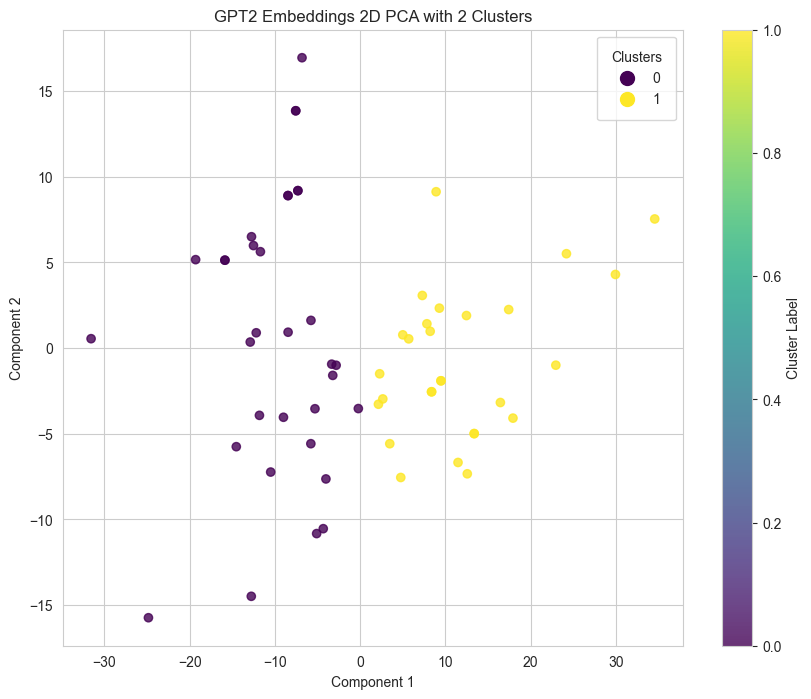

Silhouette Score: 23.94% for 3 clusters


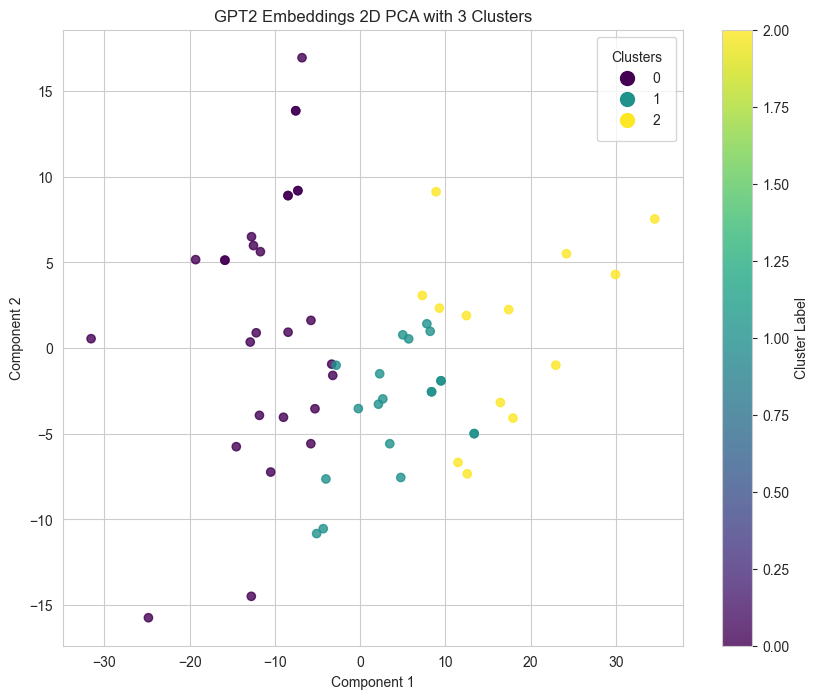

Silhouette Score: 25.58% for 4 clusters


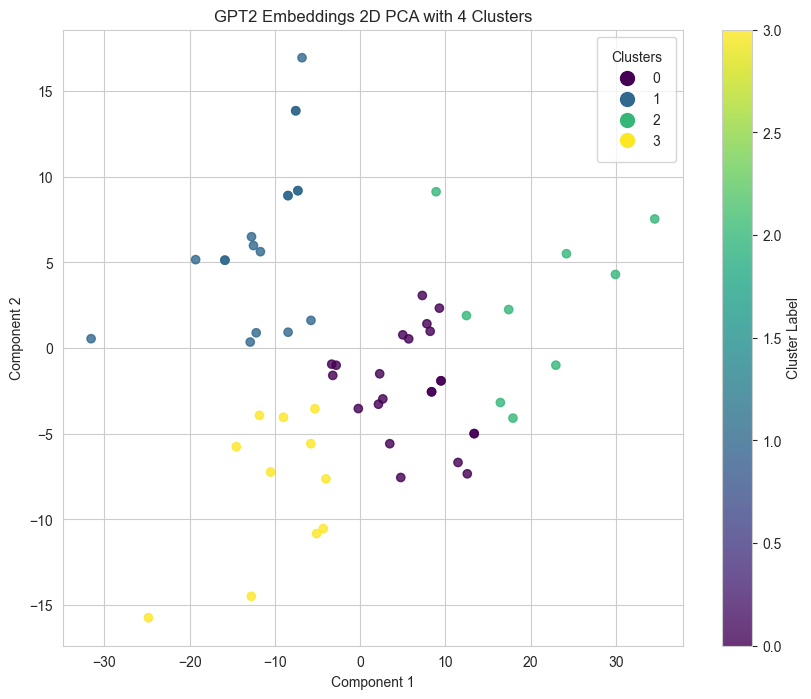

Silhouette Score: 24.16% for 5 clusters


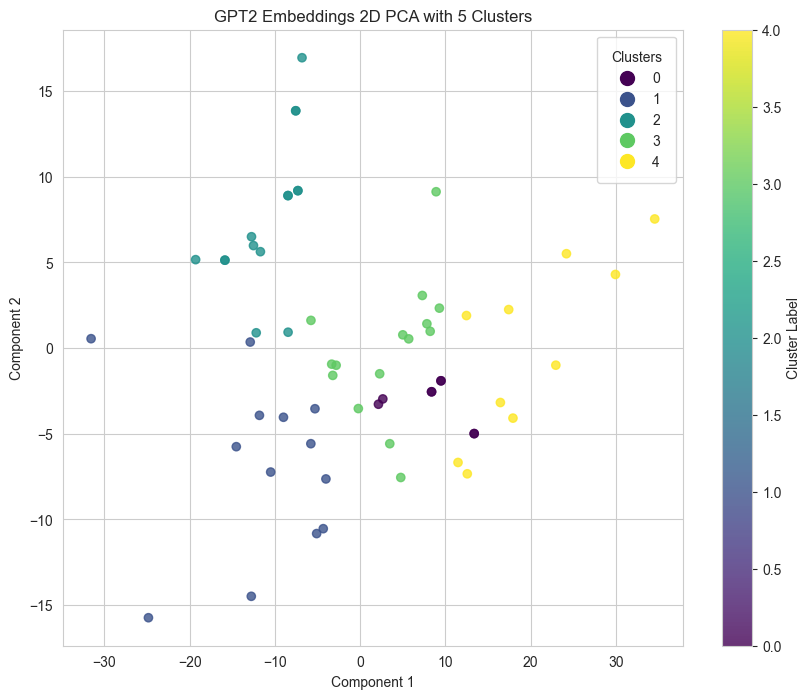

Silhouette Score: 23.16% for 6 clusters


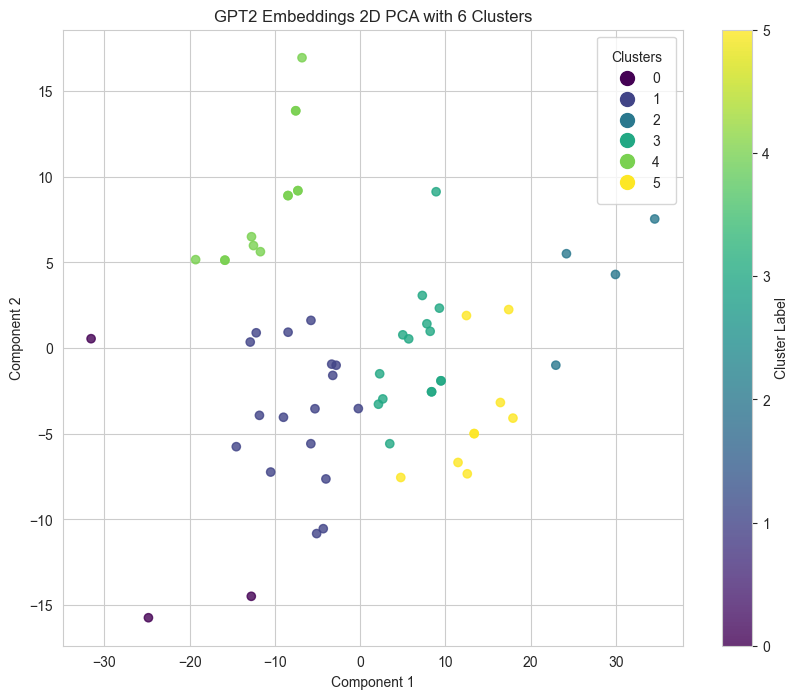

Silhouette Score: 24.28% for 7 clusters


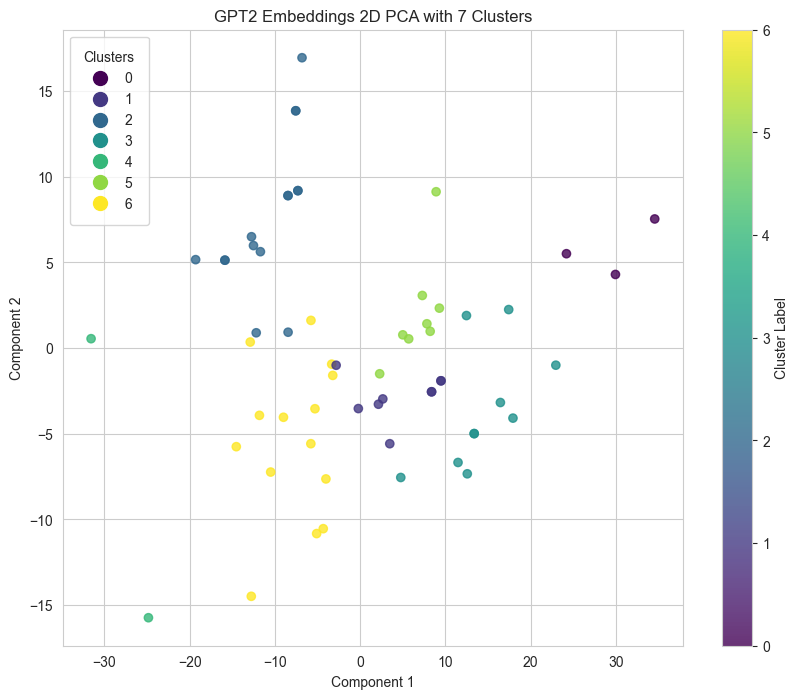

In [203]:
from sklearn.cluster import KMeans

for k in range(2, 8):
    # Clustering
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(embeddings)
    clusters = kmeans.labels_

    # Plot the results
    plot_clusters(embeddings, clusters, k)

# Add cluster labels back to the original DataFrame
df['Cluster Label'] = clusters

# Save the DataFrame with cluster labels if needed
df.to_csv('GPT_clustred_patent_claims.csv', index=False)

### 2.5 Extracting Topics using LDA

Latent Dirichlet Allocation - A statistical model for discovering the abstract topics aka topic modeling.

In [204]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Function to group by cluster label and send to LDA
def get_top_words(df_file_path):
    # Function to apply LDA to each cluster
    def apply_lda_to_cluster(texts):
        vectorizer = CountVectorizer(stop_words='english', token_pattern=r'\b[a-zA-Z]{2,}\b')
        tf = vectorizer.fit_transform(texts)
        lda = LatentDirichletAllocation(n_components=1, random_state=42)  # Only compute one topic
        lda.fit(tf)
        
        # Get the feature names
        feature_names = vectorizer.get_feature_names_out()
        
        # Get the top word from the single topic
        topic = lda.components_[0]
        top_word_index = topic.argsort()[-1]  # Get the index of the highest scoring word
        top_word = feature_names[top_word_index]  # Access the top word using its index
        
        return top_word

    df = pd.read_csv(df_file_path)
    # Group by cluster label
    grouped = df.groupby('Cluster Label')['Normalized Claim'].apply(list)
    
    top_words_from_clusters = {}  # Dictionary to store top words from each cluster
    
    # Apply LDA to each cluster and collect the top word
    for label, claims in grouped.items():
        top_word = apply_lda_to_cluster(claims)
        top_words_from_clusters[label] = top_word

    return top_words_from_clusters

In [205]:
print(get_top_words('GPT_clustred_patent_claims.csv'))

{0: 'claim', 1: 'output', 2: 'said', 3: 'output', 4: 'said', 5: 'signal', 6: 'claim'}


In [206]:
print(get_top_words('hierarchical_cluster_labels.csv'))

{1: 'said', 2: 'claim', 3: 'output', 4: 'signal'}


In [207]:
print(get_top_words('kmeans_cluster_labels.csv'))

{0: 'said', 1: 'output', 2: 'apparatus', 3: 'said'}
